In [1]:
### Project 2 Airbnb Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import glob
import datetime
import matplotlib.ticker as mtick

import plotly
import plotly.plotly as py
py.sign_in('nzahadat', 'VDBLh2LQZvNWxovGAbr8')
print(plotly.__version__)
plotly.offline.init_notebook_mode() # run at the start of every notebook


%matplotlib inline

2.0.11


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
# import & conbine data
total_listings=pd.DataFrame()
for filename in glob.iglob('./**/**/listings.csv',recursive=False):
    print(filename)
    data=pd.read_csv(filename,error_bad_lines=False,low_memory=False,encoding='ISO-8859-1')
    total_listings=total_listings.append(data)
    
    

.\2015-01-01\data\listings.csv
.\2015-03-01\data\listings.csv
.\2015-04-01\data\listings.csv
.\2015-05-01\data\listings.csv
.\2015-06-01\data\listings.csv
.\2015-08-01\data\listings.csv
.\2015-09-01\data\listings.csv
.\2015-10-01\data\listings.csv
.\2015-11-01\data\listings.csv
.\2015-12-02\data\listings.csv
.\2016-01-01\data\listings.csv
.\2016-02-02\data\listings.csv
.\2016-04-03\data\listings.csv
.\2016-05-02\data\listings.csv
.\2016-06-02\data\listings.csv
.\2016-07-02\data\listings.csv
.\2016-08-02\data\listings.csv
.\2016-09-02\data\listings.csv
.\2016-10-01\data\listings.csv
.\2016-11-02\data\listings.csv
.\2016-12-03\data\listings.csv
.\2017-01-01\data\listings.csv
.\2017-02-02\data\listings.csv
.\2017-03-02\data\listings.csv
.\2017-04-02\data\listings.csv
.\2017-05-02\data\listings.csv


In [3]:
# create row index as id + calendar_last_scraped
total_listings['id_date']=total_listings['id'].map(str)+"_"+total_listings['last_scraped']
total_listings=total_listings.set_index(['id_date'])

In [4]:
# create date column
total_listings['date']=pd.to_datetime(total_listings['last_scraped']).dt.strftime('%Y-%m')

In [109]:
(total_listings.isnull().sum()/total_listings.shape[0]*100).sort_values(ascending=False)

license                        100.000000
jurisdiction_names              99.988883
square_feet                     97.916917
host_listing_count              96.985329
monthly_price                   71.868138
has_availability                71.109022
interaction                     70.576970
access                          69.268631
notes                           67.987149
weekly_price                    65.961079
house_rules                     65.820416
security_deposit                61.594374
host_acceptance_rate            52.763448
neighborhood_overview           49.447531
transit                         45.846986
cleaning_fee                    41.884219
host_about                      34.076343
thumbnail_url                   28.751636
xl_picture_url                  28.751636
medium_url                      28.751636
space                           28.321283
reviews_per_month               26.845646
review_scores_checkin           26.711478
review_scores_value             26

In [6]:
total_listings['state'].unique()

array(['NY', nan, 'Queens NY 11377, USA', 'Ny', 'ny', 'CA', 'OR', 'OK',
       'MP', 'DO', 'NJ', 'New York', 'FL', 'CO', 'bx', 'DC', 'VT', 'MA'], dtype=object)

In [7]:
# drop rows where state is not NY, ny, Ny, New York, Queens NY 11377, USA, and bx
total_listings=total_listings.loc[total_listings['state'].isin(['NY', 'ny', 'Ny','New York','Queens NY 11377, USA', 'bx'])]


In [8]:
# check state again
total_listings['state'].unique()

array(['NY', 'Queens NY 11377, USA', 'Ny', 'ny', 'New York', 'bx'], dtype=object)

In [9]:
# clean the price formatting
total_listings['price'] = total_listings['price'].map(lambda p: int(p[1:-3].replace(",", "")))
total_listings['price'].dtype

dtype('int64')

In [10]:
# drop columns which have missing value over 20% and columns that are not related to analysis

total_listings_clean=total_listings.dropna(thresh=0.80*total_listings.shape[0],axis=1)
total_listings_clean.dropna(how='all', inplace=True)
total_listings_clean=total_listings_clean.drop(['calendar_updated','country_code','country','experiences_offered',
                                                'host_total_listings_count','market','neighbourhood','neighbourhood_group_cleansed',
                                                'scrape_id','smart_location','street','summary','host_picture_url',
                                               'host_thumbnail_url','host_url','listing_url','picture_url',
                                                'calendar_last_scraped'],axis=1)

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [11]:
list(total_listings_clean)

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cancellation_policy',
 'city',
 'description',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_since',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'state',
 'zipcode',
 'date']

In [12]:
# convert features to boolean
for feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    total_listings_clean[feature] = total_listings_clean[feature].map(lambda s: False if s == "f" else True)

In [13]:
# create dummmies for property characteristics
features = pd.DataFrame()
for feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(total_listings_clean[feature])], axis=1)

#total_listings_clean.drop(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type'],axis=1, inplace=True)
total_listings_clean=total_listings_clean.merge(features,left_index=True,right_index=True)


In [14]:
# parse amenities
total_listings_clean.amenities = total_listings_clean.amenities.str.replace("[{}]", "")
total_listings_clean.amenities = total_listings_clean.amenities.str.replace('"', '')
amenities = total_listings_clean.amenities.str.get_dummies(sep = ",")


In [15]:
amenities.shape


(908557, 122)

In [16]:
amenities


,24-Hour Check-in,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air Conditioning,Air conditioning,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
id_date,,,,,,,,,,,,,,,,,,,,,
1069266_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1846722_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2061725_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44974_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4701675_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68914_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4832596_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2562510_2015-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3005360_2015-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
feature

'bed_type'

In [18]:
# merge edited amenities back to total_listings
total_listings_clean_ame=total_listings_clean.merge(amenities,left_index=True,right_index=True)
total_listings_clean_ame.dropna(subset=['amenities'], inplace=True) 
total_listings_clean_ame.drop(['amenities'],axis=1, inplace=True)
total_listings_clean_ame

,accommodates,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,...,Wheelchair Accessible,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower and toilet,Wide doorway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
id_date,,,,,,,,,,,,,,,,,,,,,
4622922_2015-08-01,2,0.0,212.0,0.0,0.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
958444_2015-08-01,4,5.0,279.0,5.0,6.0,1.0,Real Bed,1.0,2.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3943387_2015-08-01,2,0.0,326.0,21.0,51.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3362669_2015-08-01,2,20.0,347.0,42.0,72.0,1.0,Real Bed,1.0,2.0,1.0,...,0,0,0,0,0,0,0,1,0,0
6627449_2015-08-01,3,6.0,309.0,8.0,34.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
5557381_2015-08-01,4,16.0,339.0,41.0,71.0,1.0,Real Bed,1.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1886820_2015-08-01,4,0.0,239.0,0.0,0.0,3.0,Real Bed,3.0,3.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4462008_2015-08-01,2,4.0,319.0,17.0,44.0,1.0,Real Bed,1.0,2.0,4.0,...,0,0,0,0,0,0,0,1,0,0
260566_2015-08-01,2,3.0,155.0,3.0,3.0,1.0,Real Bed,1.0,2.0,5.0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
list(total_listings_clean)

['accommodates',
 'amenities',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'cancellation_policy',
 'city',
 'description',
 'extra_people',
 'guests_included',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_since',
 'host_verifications',
 'id',
 'instant_bookable',
 'is_location_exact',
 'last_scraped',
 'latitude',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'name',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'price',
 'property_type',
 'require_guest_phone_verification',
 'require_guest_profile_picture',
 'requires_license',
 'room_type',
 'state',
 'zipcode',
 'date',
 'Allerton',
 'Alphabet City',
 'Arden Heights',
 'Arrochar',
 'Arverne',
 'Astoria',
 'Bath Beach',
 'Battery Park City',
 'Bay Ridge',
 'Bay Terrace',
 'Bay Terrace, Staten Island',

In [20]:
# number of listings over time
data_number_of_listings=total_listings.groupby(['date']).size()
data_number_of_listings.head()

date
2015-01    27390
2015-03    27097
2015-04    27408
2015-05    27316
2015-06    27465
dtype: int64

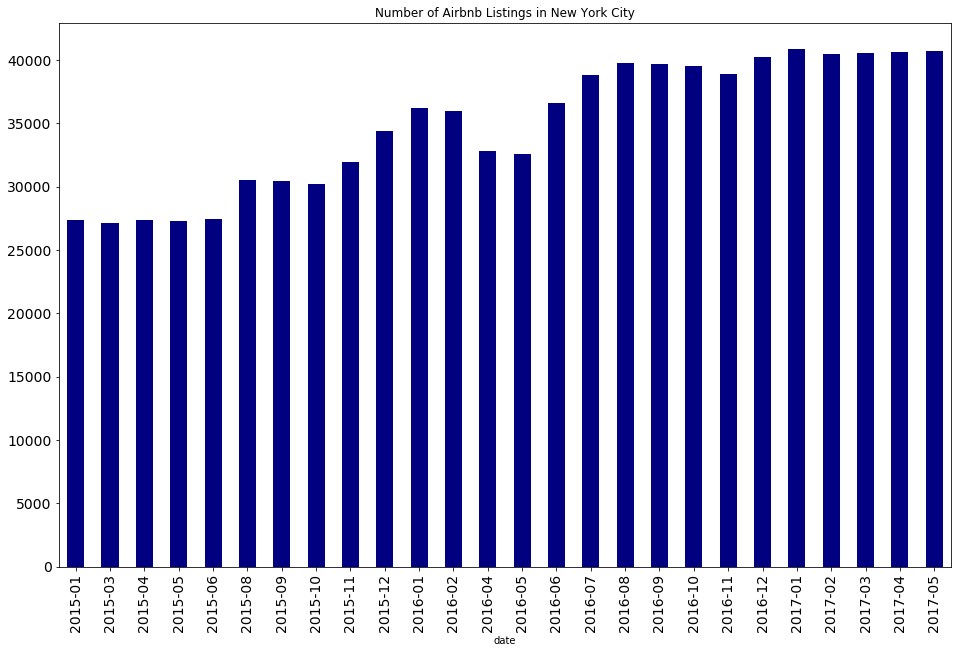

In [112]:
# graph number of listings over time
data_number_of_listings.plot(kind='bar',figsize=(16,10),legend=False, color='navy',fontsize=14,
                             title='Number of Airbnb Listings in New York City')


In [22]:
# total size of listings in squared feet over time: approximated by using number of bedrooms and bathrooms
total_listings['size']=(total_listings['bedrooms']+0.5*total_listings['bathrooms'])*150
data_size_of_listings=total_listings[['date','size']].dropna(0)
data_size_of_listings=data_size_of_listings.groupby('date').sum()


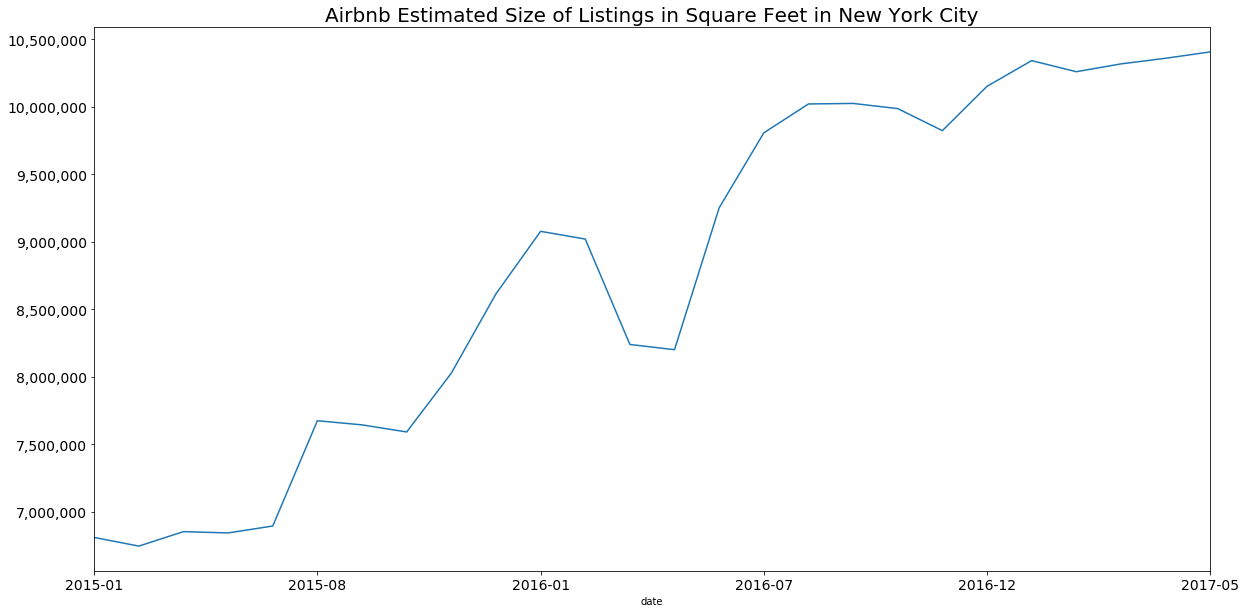

In [113]:
# graph size of listings over time
ax=data_size_of_listings.plot(figsize=(20,10),fontsize=14,legend=False)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.set_title('Airbnb Estimated Size of Listings in Square Feet in New York City',fontsize=20)

In [86]:
# listing room type percentage in May 2017
total_listings_room_type=total_listings_clean[['date','Entire home/apt', 'Private room', 'Shared room']]
room_type=total_listings_room_type[total_listings_room_type['date']=='2017-05'].size/len(total_listings_room_type[total_listings_room_type['date']==date])


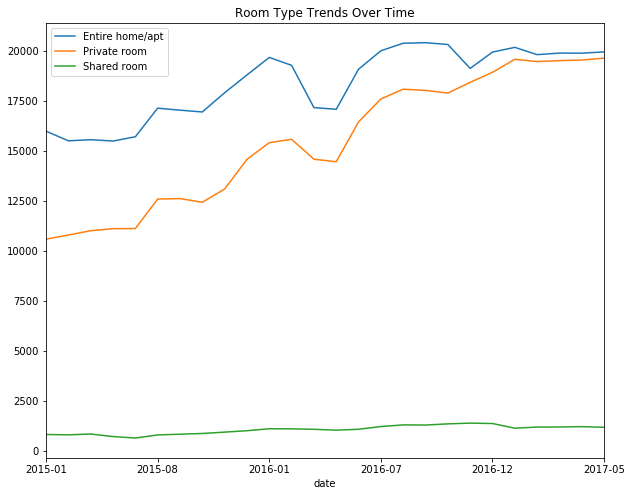

In [110]:
total_listings_room_type.groupby('date').sum().plot(title='Room Type Trends Over Time',figsize=(10,8))

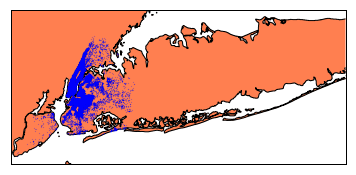

In [74]:
# listing geo graph of May 2017 using Plotly

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
;
df = total_listings[['id','latitude','longitude','zipcode','neighbourhood_cleansed','date']]
df = df[df['date']=='2017-05']
my_map = Basemap(projection='merc', lat_0 = 40, lon_0 = -73,
    resolution = 'f', area_thresh = 0.01,
    llcrnrlon=-74.2700, llcrnrlat=40.4700,
    urcrnrlon=-72.7500, urcrnrlat=41.0000,
                epsg=3857)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = 'coral')
my_map.drawmapboundary()

lon = df['longitude'].values
lat = df['latitude'].values
x,y = my_map(lon, lat)
my_map.plot(x, y, 'bo', markersize=0.1)

In [ ]:
total_listings[total_listings['date']=='2015-05'].sum()

In [37]:
total_listings_room_type.head()


,date,Entire home/apt,Private room,Shared room
id_date,,,,
1069266_2015-01-02,2015-01,1,0,0
1846722_2015-01-02,2015-01,1,0,0
2061725_2015-01-02,2015-01,0,1,0
44974_2015-01-03,2015-01,1,0,0
4701675_2015-01-02,2015-01,1,0,0


In [44]:
total_listings[['id','latitude','longitude','zipcode','neighbourhood_cleansed','date']]

,id,latitude,longitude,zipcode,neighbourhood_cleansed,date
id_date,,,,,,
1069266_2015-01-02,1069266,40.756852,-73.964754,10022,Midtown East,2015-01
1846722_2015-01-02,1846722,40.830599,-73.941014,NaN,Hamilton Heights,2015-01
2061725_2015-01-02,2061725,40.692189,-73.924120,11221,Bushwick,2015-01
44974_2015-01-03,44974,40.734751,-74.002592,10011,West Village,2015-01
4701675_2015-01-02,4701675,40.745282,-73.997836,10011,Chelsea,2015-01
68914_2015-01-02,68914,40.679060,-73.994730,11231,Carroll Gardens,2015-01
4832596_2015-01-03,4832596,40.684422,-73.909882,11207,Bushwick,2015-01
2562510_2015-01-02,2562510,40.719319,-73.997247,10013,Chinatown,2015-01
3005360_2015-01-03,3005360,40.726022,-73.986418,10003,East Village,2015-01
